In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Tracking

## 1. KLT Tracker

First we briefly go over KLT tracker. The idea of KLT is largely two parts:

1. There are some features that are very suitable for tracking. In this case, it's called Shi-Tomasi detector. It's shown that they are more robust than SIFT or others in the case of tracking

2. After we have features, we Lucas and Kanade's method assumes that between two nearby frames (in terms of time), the appearance of a small patch around each feature would remain nearly constant except for a small translation (displacement). You can thus do tracking by computing such a flow.

In [ ]:
# Load a sample video (change this path to your video file)
cap = cv2.VideoCapture('strawberry_video_easy.mp4')

feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7)

lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params) # yes, tomasi-shi feature is literally called goodFeaturesToTrack in OpenCV
color = np.random.randint(0, 255, (100, 3))
mask = np.zeros_like(old_frame)

frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    if p1 is None:
        break
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)
    frames.append(img.copy())
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cap.release()

In [ ]:
# Save output video
output_path = "klt_output.mp4"
imageio.mimsave(output_path, [cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in frames], fps=20)

## 2. YOLO-Based Tracking

Now, we will talk about a deep learning-based method called Yolo. It's something pretty widely used in the real world.

As you may have noticed, KLT tracker has no semantic meaning, which limits its real-world use case. Besides, it makes some assumptions that don't really hold up well in the real world.

In [ ]:
!pip install ultralytics lap
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
model = YOLO('yolov10s.pt') # YOLO automatically download pretrained weights for you

100%|██████████| 15.9M/15.9M [00:00<00:00, 478MB/s]


In [ ]:
video_path = 'strawberry_video_easy.mp4'
results = model.track(source=video_path, conf=0.3, save=True)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/130) /content/strawberry_video_easy.mp4: 384x640 (no detections), 59.9ms
video 1/1 (frame 2/130) /content/strawberry_video_easy.mp4: 384x640 (no detections), 10.3ms
video 1/1 (frame 3/130) /content/strawberry_video_easy.mp4: 384x640 (no detections), 11.0ms
video 1/1 (frame 4/130) /content/strawberry_video_easy.mp4: 384x640 (no detections), 10.2ms
video 1/1 (frame 5/130) /content/strawberry_video_easy.mp4: 384x640 (no detections), 10.

The result is not good, why?

Well, YOLO is pretrained on the COCO dataset, and if we look at the [label list](https://github.com/amikelive/coco-labels/blob/master/coco-labels-paper.txt) of the COCO dataset, we realize that it doesn't have strawberry in the first place.

YOLO-based tracking is a tracking by detection method. Basically, it first needs to detect the object of interest in every frame, and then figure out a way to associate them (SORT introduced in the class is one of the options)

So, to be able to track an object, we must be able to detect it first.

Since YOLO models are trained on a dataset that doesn't have strawberry, how can we make it to detect strawberry?

We will finetuning a YOLO model! But first, let's get some data

### 2.1 Data Labelling

There are many ways to acquire labeled data, but first, let's get a taste of labeling data ourselves.

We will use [Roboflow](https://roboflow.com/) to do our data labeling. There are many similar tools out there that can achieve a similar end result.

Note that, since we are finetuning YOLO models, when we lable the data we need to follow the YOLO dataset format. Many data labelling tool will let you choose what format to generate before you start labelling.

For Roboflow, we can just label it and when we download/export our data, we can choose what dataset format to generate

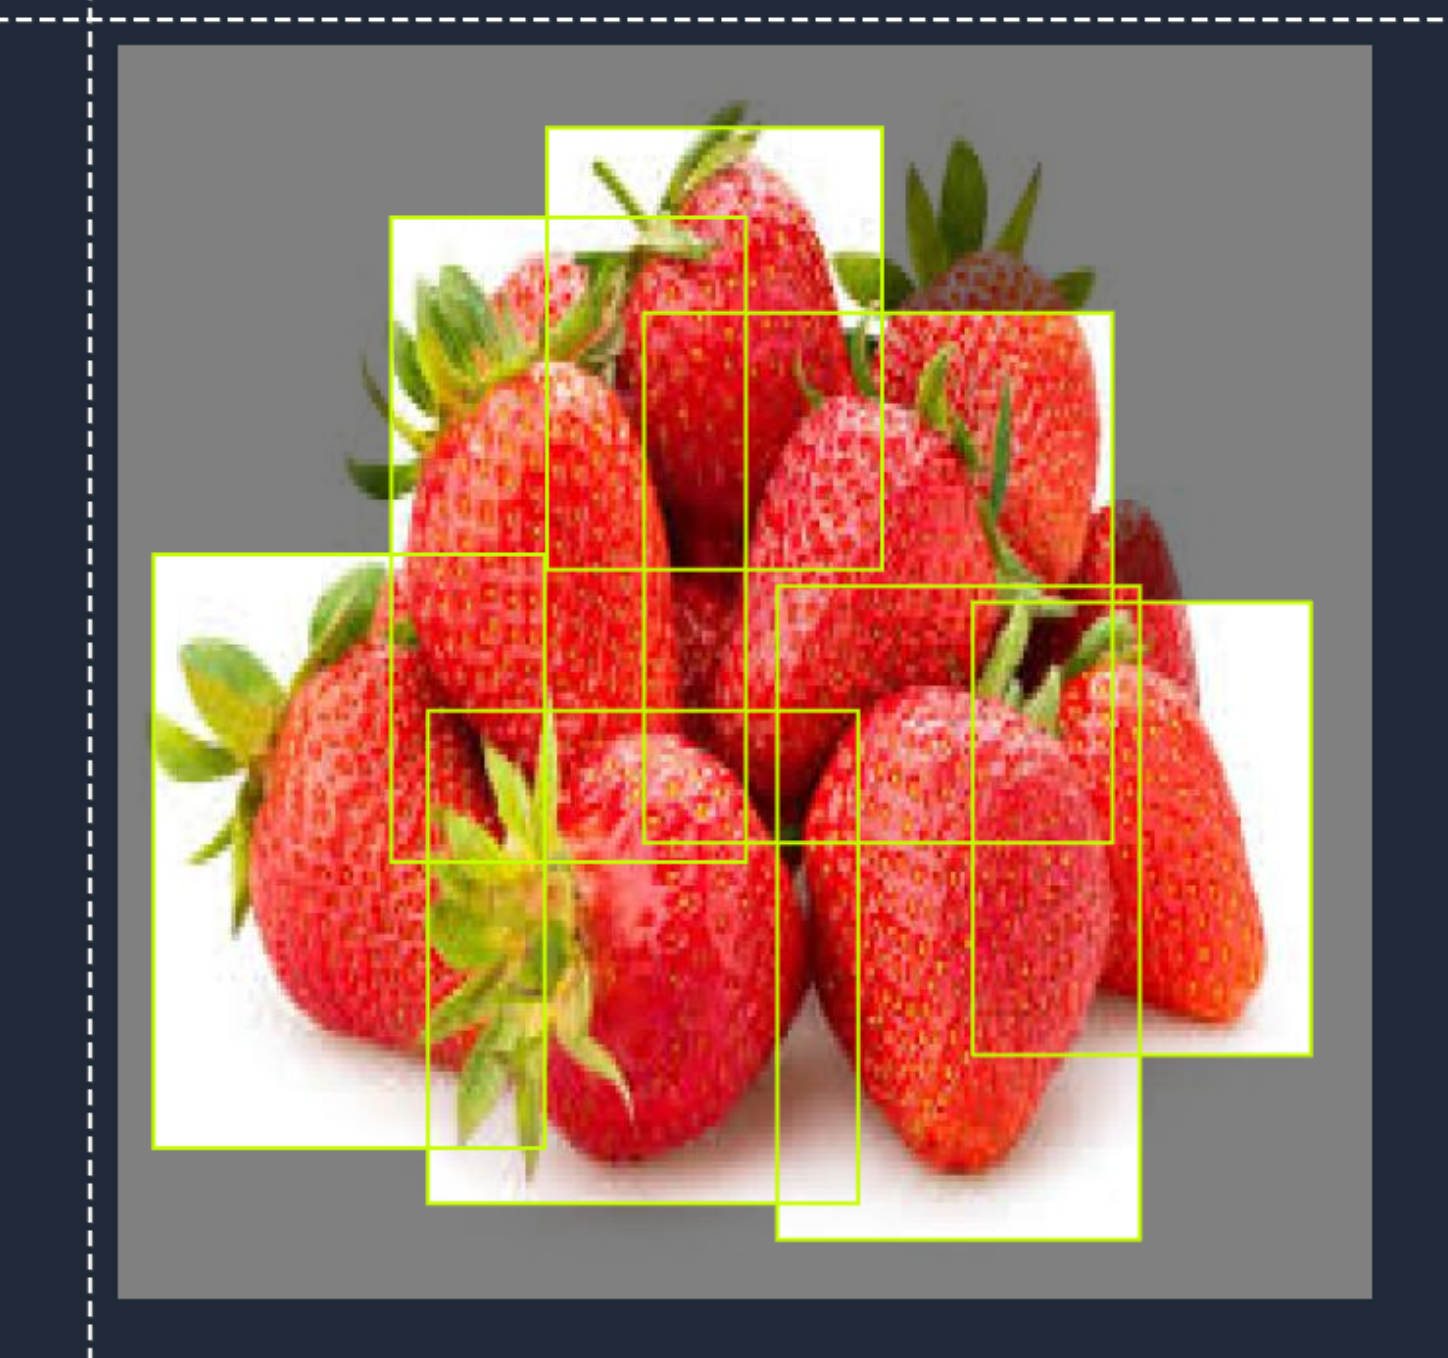

### 2.2 Online Dataset

As we quickly notice, labelling data like this is very tedious. Luckily, we are not the first one to think of doing strawberry detection, and some of the people who did this before us are nice enough to provide their labelled data for free.

[Here](https://universe.roboflow.com/swaraj-8siq5/strawberry-detection-n8kqe) is one of them on Roboflow.

Let's download them following YOLO's format. YOLO's format hasn't changed a lot recently, so any reasonably new format would do.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="OHAH4qZmwAbdOtO9P8Ry")
project = rf.workspace("swaraj-8siq5").project("strawberry-detection-n8kqe")
version = project.version(1)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Strawberry-Detection-1 in yolov11:: 100%|██████████| 554/554 [00:00<00:00, 8654.91it/s]


### 2.3 Finetuning

Now let's do our finetuning.

What's finetuning anyway?

Traditionally, a machine learning task works like this: we collect some data, we train a model from scratch, and we run this model on unseen data to solve the problem.

Then, people realized that we don't need to train everything from the very beginning. We can get a well-trained model, use a small batch of data to further train it a little bit, and it would achieve great results

As humans, we demonstrate this kind of capability all the time. Imagine learning to play baseball as a kid. You don't need to learn how to run, how to throw things, or how to hold a bat. You already learned this throughout your developmental years. You just need to learn a little bit about things specific to baseball to be able to do play.

In [ ]:
model.train(data=r'/content/Strawberry-Detection-1/data.yaml', epochs=30, batch=32, imgsz=640)

Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10s.pt, data=/content/Strawberry-Detection-1/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 79.2MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

 23        [16, 19, 22]  1   1639574  ultralytics.nn.modules.head.v10Detect        [1, [128, 256, 512]]          
YOLOv10s summary: 234 layers, 8,067,126 parameters, 8,067,110 gradients, 24.8 GFLOPs

Transferred 607/619 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 321MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 25.9±8.4 MB/s, size: 58.5 KB)


train: Scanning /content/Strawberry-Detection-1/train/labels... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 799.17it/s]


train: New cache created: /content/Strawberry-Detection-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 12.7±5.4 MB/s, size: 46.8 KB)


val: Scanning /content/Strawberry-Detection-1/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 338.98it/s]

val: New cache created: /content/Strawberry-Detection-1/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      9.19G      4.013      27.66      4.532         71        640: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         23         52      0.114      0.231     0.0672     0.0199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      9.22G      3.644      23.36       4.09         81        640: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         23         52      0.484      0.442      0.403      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      9.33G      2.807      9.578      3.207         55        640: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         23         52     0.0323      0.135     0.0268     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      9.25G      2.984      4.611      3.192         84        640: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         23         52     0.0012      0.154   0.000681   0.000192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      9.29G      3.124      3.329       3.32         81        640: 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         23         52    0.00478      0.173    0.00276   0.000872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      9.28G      3.073      2.658      3.321         48        640: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         23         52     0.0734      0.115     0.0284    0.00829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      9.26G      3.131       2.58       3.36         68        640: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         23         52   0.000799     0.0192    0.00019    1.9e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      9.25G      3.034      2.379      3.284         57        640: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         23         52     0.0185     0.0192     0.0044    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      9.26G        3.1       2.37      3.373         42        640: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         23         52     0.0285      0.154     0.0135    0.00472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.25G      2.895      2.117      3.189         68        640: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         23         52     0.0526      0.192     0.0232    0.00899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      9.25G      2.849      2.021      3.185         80        640: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         23         52     0.0295      0.404     0.0192    0.00911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       9.3G      2.989      2.193      3.208         75        640: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         23         52      0.417      0.212      0.201     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      9.26G      2.882      2.046      3.115         78        640: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         23         52      0.134      0.346     0.0916     0.0236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      9.29G      2.792       1.96      3.048         62        640: 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         23         52      0.346      0.224      0.212     0.0515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30       9.3G      2.773      1.961       3.02         70        640: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         23         52      0.312      0.515      0.283      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      9.26G      2.633      1.886       2.97         75        640: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         23         52      0.419      0.462      0.436      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      9.29G      2.708      1.979      2.954         62        640: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         23         52      0.554      0.577      0.582        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      9.31G      2.695      1.941      3.017         47        640: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         23         52      0.738      0.865      0.872      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      9.32G      2.496      1.791      2.863         73        640: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         23         52      0.773      0.904      0.917      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       9.3G      2.368      1.723      2.816         76        640: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         23         52      0.801      0.942      0.944      0.575


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      9.25G      2.059      1.364      2.718         21        640: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         23         52      0.827      0.942      0.945      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      9.21G      2.066      1.241        2.7         42        640: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         23         52      0.827      0.923      0.937      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      9.21G      2.015      1.179      2.637         31        640: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         23         52      0.837      0.942      0.955      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      9.29G      1.863      1.021       2.57         32        640: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         23         52      0.902      0.883      0.954      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      9.26G      1.911       1.11      2.559         30        640: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         23         52      0.875      0.904       0.97      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      9.25G      1.769      1.004      2.453         35        640: 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         23         52      0.908      0.949      0.967      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      9.21G      1.706     0.9966      2.438         54        640: 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         52      0.904      0.942      0.974      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      9.26G      1.611     0.8982      2.363         40        640: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         23         52      0.907      0.962      0.981      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      9.26G      1.539     0.8636      2.331         41        640: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23         52      0.918      0.904      0.972      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      9.26G      1.521     0.8231      2.333         25        640: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         23         52      0.834      0.966      0.971      0.639



30 epochs completed in 0.056 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 16.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


                   all         23         52      0.957      0.862      0.972      0.639
Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4109371cd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### 2.4 Tracking

In [ ]:
results = model.track(source='/content/strawberry_video_easy.mp4', tracker='botsort.yaml', save=True)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/130) /content/strawberry_video_easy.mp4: 384x640 1 strawberry, 68.1ms
video 1/1 (frame 2/130) /content/strawberry_video_easy.mp4: 384x640 1 strawberry, 61.6ms
video 1/1 (frame 3/130) /content/strawberry_video_easy.mp4: 384x640 1 strawberry, 34.4ms
video 1/1 (frame 4/130) /content/strawberry_video_easy.mp4: 384x640 1 strawberry, 15.3ms
video 1/1 (frame 5/130) /content/strawberry_video_easy.mp4: 384x640 1 strawberry, 16.2ms
video 1/1 (

In [ ]:
results = model.track(source='/content/strawberry_video_hard.mp4', tracker='botsort.yaml', save=True)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/838) /content/strawberry_video_hard.mp4: 384x640 1 strawberry, 13.8ms
video 1/1 (frame 2/838) /content/strawberry_video_hard.mp4: 384x640 1 strawberry, 11.4ms
video 1/1 (frame 3/838) /content/strawberry_video_hard.mp4: 384x640 1 strawberry, 23.4ms
video 1/1 (frame 4/838) /content/strawberry_video_hard.mp4: 384x640 1 strawberry, 57.4ms
video 1/1 (frame 5/838) /content/strawberry_video_hard.mp4: 384x640 1 strawberry, 37.1ms
video 1/1 (

The result on the hard video is not as good. Could you think of some reason for its worse performance?

## 3. More Heavy-Duty Tools

Of course, in the age of AI, there are more heavy-duty tools out there.

They may not be a very good fit for robotics in some cases, but it's good to know they exist

For example, Meta's Segment Anything series (https://sam2.metademolab.com/) is very powerful (although the demo is frequently offline due to heavy compute demand)